In [1]:
%%capture
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2

In [2]:
%%capture
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

In [3]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import shap

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [4]:
PATH       = "/kaggle/input/playground-series-s5e9/"
train      = pd.read_csv(PATH + "train.csv", index_col='id') #.drop('id', axis=1)
test       = pd.read_csv(PATH + "test.csv", index_col='id') #.drop('id', axis=1)

orig       = pd.read_csv("/kaggle/input/bpm-prediction-challenge/Train.csv")
orig['id'] = np.arange(len(orig))
orig       = orig.set_index('id')

submit     = pd.read_csv(PATH+"sample_submission.csv")

TARGET     = "BeatsPerMinute"
FEATURES   = test.columns.tolist()

LEN_TRAIN  = len(train)
LEN_TEST   = len(test)
LEN_ORIG   = len(orig)

In [5]:
def distplots_data(
                    train: pd.DataFrame,
                    test: pd.DataFrame,
                    orig: pd.DataFrame,
                    features: list[str]):

    df = pd.concat([train[features].assign(Source = 'Train'), 
                    test[features].assign(Source = 'Test'),
                    orig[features].assign(Source = 'Original'),], 
                    axis=0, ignore_index = True)

    fig, axs = plt.subplots(len(features), 2 ,figsize = (18, len(features) * 4), 
                            gridspec_kw = {
                                            'hspace': 0.2, 
                                            'wspace': 0.15, 
                                            'width_ratios': [0.7, 0.3]
                                    }
                    )
    PALETTE = ['g', 'r', 'orange']
    for i, col in enumerate(features):
        ax = axs[i, 0]
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = PALETTE, ax = ax, linewidth = 2
                   )
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"\n{col}")
        ax.grid()

        ax = axs[i, 1]
        sns.boxplot(data = df, y=col, x=df['Source'], width = 0.5,
                    linewidth = 1, fliersize= 1, ax = ax, palette = PALETTE)
        ax.set_title(f"\n{col}")
        ax.set(xlabel = '', ylabel = '')
        ax.tick_params(axis='both', which='major')
        ax.set_xticklabels(['Train', 'Test', 'Original'])

    plt.tight_layout()
    plt.show()


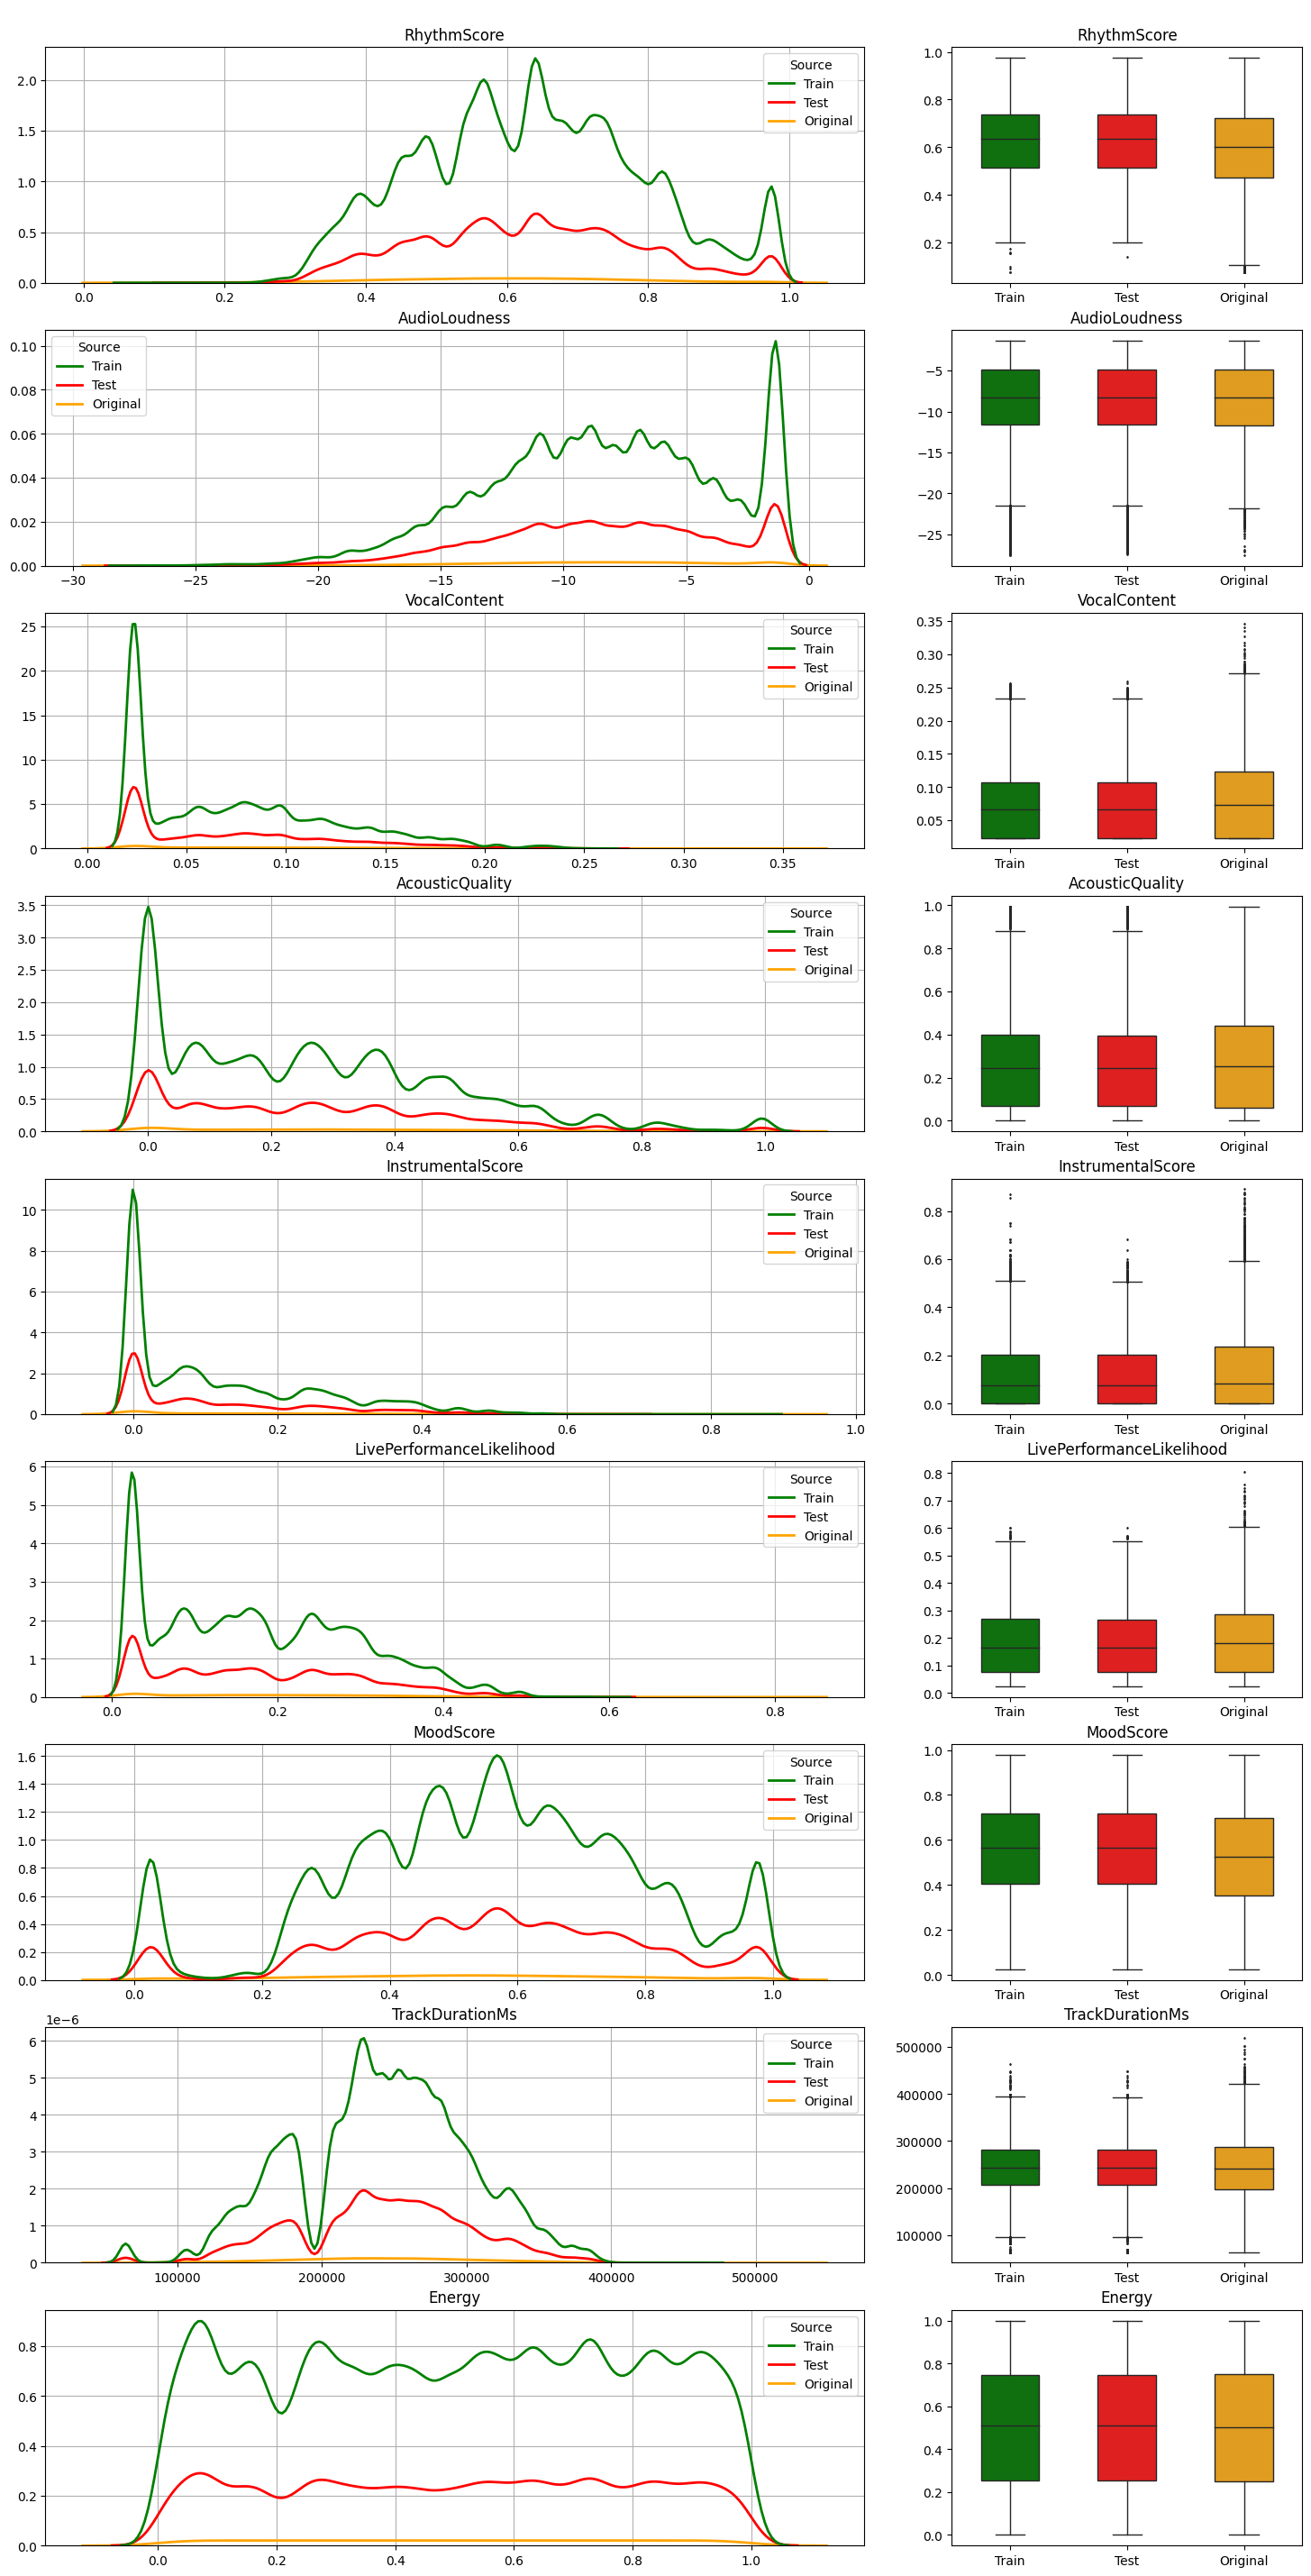

In [6]:
distplots_data(train, test, orig, FEATURES)

In [7]:
# ## -- CREATE FEATURES -- ##
# def create_features(train, test):
#     train = train.copy()
#     test  = test.copy()
#     ## -- Feature 1: Use original as features
#     ORIG_FEATURES = []
#     print(f"Merging {len(FEATURES)} features... ", end="")
#     for c in FEATURES:
#         tmp = orig.groupby(c)[TARGET].mean()
#         n = f"orig_{c}"
#         print(f"{n}, ",end="")
#         tmp.name = n
#         train = train.merge(tmp, on=c, how='left')
#         test = test.merge(tmp, on=c, how='left')
#         ORIG_FEATURES.append(n)
        
#     print()

#     # Feature 2: Scaling
#     for df in [train, test]:
#         df["TrackDurationMin"] = df["TrackDurationMs"] / 60000
#         df["log_AcousticQuality"] = np.log1p(df["AcousticQuality"]).astype('float32')
#         df["sqrt_InstrumentalScore"] = np.sqrt(df["InstrumentalScore"]).astype('float32')
#         df["sqrt_VocalContent"] = np.sqrt(df["VocalContent"]).astype('float32')
#         df["sqrt_LivePerformance"] = np.sqrt(df["LivePerformanceLikelihood"]).astype('float32')

#         df["orig_TrackDurationMin"] = df["orig_TrackDurationMs"] / 60000
#         df["log_orig_AcousticQuality"] = np.log1p(df["orig_AcousticQuality"]).astype('float32')
#         df["sqrt_orig_InstrumentalScore"] = np.sqrt(df["orig_InstrumentalScore"]).astype('float32')
#         df["sqrt_orig_VocalContent"] = np.sqrt(df["orig_VocalContent"]).astype('float32')
#         df["sqrt_orig_LivePerformance"] = np.sqrt(df["orig_LivePerformanceLikelihood"]).astype('float32')

#     # ## -- Feature 3: Interactions
#     # X_INTERACTS = []
#     # D_INTERACTS = []
#     # for n in [2]:
#     #     for cols in tqdm(list(combinations(FEATURES, n)), desc="Creating interactions"):
#     #         ## -- Multiplication
#     #         n1 = '_x_'.join(sorted(cols))
#     #         train[n1] = (train[cols[0]] * train[cols[1]]).astype('float32')
#     #         test[n1] = (test[cols[0]] * test[cols[1]]).astype('float32')
#     #         Division
#     #         n2 = '_/_'.join(sorted(cols))
#     #         train[n2] = (train[cols[0]] / (train[cols[1]] + 1e-6)).astype('float32')
#     #         test[n2] = (test[cols[0]] / (test[cols[1]] + 1e-6)).astype('float32')
#     #         ## -- Inverse Division
#     #         n3 = '_\_'.join(sorted(cols))
#     #         train[n3] = (train[cols[1]] / (train[cols[0]] + 1e-6)).astype('float32')
#     #         test[n3] = (test[cols[1]] / (test[cols[0]] + 1e-6)).astype('float32')

#     #         ## -- X_INTERACTS.append(n1)
#     #         D_INTERACTS.append(n2)
#     #         D_INTERACTS.append(n3)
    
#     ## -- Feature 4: Quartile and Decile features
#     QT = 4
#     DE = 10
#     BINS = []
    
#     print(f"-> Creating {QT} & {DE} bins:")
#     for i, col in enumerate(FEATURES, 1):
#         print(f"Feat_{i}.. ", end="")

#         # Calculate quantiles based on the training set
#         QT_TRAIN = pd.qcut(train[col], q=QT, labels=False, duplicates='drop')
#         DE_TRAIN = pd.qcut(train[col], q=DE, labels=False, duplicates='drop')
        
#         QUAD = f"qt_{col.lower()}"
#         DECI  = f"de_{col.lower()}"
#         # Add binned features to train
#         train[QUAD] = QT_TRAIN
#         train[DECI] = DE_TRAIN

#         # Use the training quantiles to bin the test set
#         QT_BINS = train[col].quantile(np.linspace(0, 1, QT+1))
#         DE_BINS = train[col].quantile(np.linspace(0, 1, DE+1))
        
#         EXTRA = dict(labels=False, include_lowest=True, duplicates='drop')
        
#         test[QUAD] = pd.cut(test[col], bins=QT_BINS, **EXTRA)
#         test[DECI] = pd.cut(test[col], bins=DE_BINS, **EXTRA)

#         # Handle cases where pd.cut returns NaN
#         test[QUAD] = test[QUAD].fillna(-1)
#         test[DECI] = test[DECI].fillna(-1)

#         BINS.append(QUAD)
#         BINS.append(DECI)

#     # Feature 5: Pairwise combinations
#     TE_columns = []
#     for n in [2]:
#         for cols in tqdm(list(combinations(BINS, n)), desc="Creating combinations"):
#             name = '-'.join(sorted(cols))

#             # Create combos by concatenating string representations
#             train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
#             test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

#             # if n == 3: # --> Create 3-combo
#             #     train[name] += '_' + train[cols[2]].astype(str)
#             #     test[name] += '_' + test[cols[2]].astype(str)

#             # Fit the category encoder ONLY on the training data
#             train[name] = train[name].astype('category')
#             cat = train[name].cat
#             # Apply consistent encoding across datasets
#             train[name] = train[name].cat.codes
#             # Use the fitted category to transform the test and original sets
#             test[name] = pd.Categorical(test[name], categories=cat.categories).codes

#             TE_columns.append(name)

        
#     ##### ===================== ORIGINAL DATA OPERATIONS ======================== ###
#     orig_BINS = []
    
#     print(f"-> Creating {QT} & {DE} bins - ORIGNAL:")
#     for i, col in enumerate(ORIG_FEATURES, 1):
#         print(f"Feat_{i}.. ", end="")

#         # Calculate quantiles based on the training set
#         QT_TRAIN = pd.qcut(train[col], q=QT, labels=False, duplicates='drop')
#         DE_TRAIN = pd.qcut(train[col], q=DE, labels=False, duplicates='drop')
        
#         QUAD = f"qt_{col.lower()}"
#         DECI  = f"de_{col.lower()}"
#         # Add binned features to train
#         train[QUAD] = QT_TRAIN
#         train[DECI] = DE_TRAIN

#         # Use the training quantiles to bin the test set
#         QT_BINS = train[col].quantile(np.linspace(0, 1, QT+1))
#         DE_BINS = train[col].quantile(np.linspace(0, 1, DE+1))
        
#         EXTRA = dict(labels=False, include_lowest=True, duplicates='drop')
        
#         test[QUAD] = pd.cut(test[col], bins=QT_BINS, **EXTRA)
#         test[DECI] = pd.cut(test[col], bins=DE_BINS, **EXTRA)

#         # Handle cases where pd.cut returns NaN
#         test[QUAD] = test[QUAD].fillna(-1)
#         test[DECI] = test[DECI].fillna(-1)

#         orig_BINS.append(QUAD)
#         orig_BINS.append(DECI)
    
#     # Feature 5: Pairwise combinations
#     orig_TE_columns = []
#     for n in [2]:
#         for cols in tqdm(list(combinations(orig_BINS, n)), desc="Creating combinations -  ORIGINAL"):
#             name = '-'.join(sorted(cols))

#             # Create combos by concatenating string representations
#             train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
#             test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

#             # if n == 3: # --> Create 3-combo
#             #     train[name] += '_' + train[cols[2]].astype(str)
#             #     test[name] += '_' + test[cols[2]].astype(str)

#             # Fit the category encoder ONLY on the training data
#             train[name] = train[name].astype('category')
#             cat = train[name].cat
#             # Apply consistent encoding across datasets
#             train[name] = train[name].cat.codes
#             # Use the fitted category to transform the test and original sets
#             test[name] = pd.Categorical(test[name], categories=cat.categories).codes

#             orig_TE_columns.append(name)
            
#     print("Feature Engineering Complete!!!")
#     print(f"-> Binned features   : {len(BINS+orig_BINS)}")
#     print(f"-> Combinations (TE) : {len(TE_columns+orig_TE_columns)}")
#     print(f"---> TOTAL FEATURES  : {len(test.columns)}")

#     return train, test

In [8]:
## -- CREATE FEATURES -- ##
def create_features(train, test):
    # Feature 1: Scaling
    for df in [train, test]:
        df["TrackDurationMin"] = df["TrackDurationMs"] / 60000
        df["log_AcousticQuality"] = np.log1p(df["AcousticQuality"])
        df["sqrt_InstrumentalScore"] = np.sqrt(df["InstrumentalScore"])
        df["sqrt_VocalContent"] = np.sqrt(df["VocalContent"])
        df["sqrt_LivePerformance"] = np.sqrt(df["LivePerformanceLikelihood"])

    QT = 4
    DE = 10
    BINS = []
    
    print(f"Creating {QT} & {DE} bins:")
    for i, col in enumerate(FEATURES, 1):
        print(f"Col-{i}.. ", end="")

        # Calculate quantiles based on the training set
        QT_TRAIN = pd.qcut(train[col], q=QT, labels=False, duplicates='drop')
        DE_TRAIN = pd.qcut(train[col], q=DE, labels=False, duplicates='drop')
        
        QUAD = f"qt_{col.lower()}"
        DECI  = f"de_{col.lower()}"
        # Add binned features to train
        train[QUAD] = QT_TRAIN
        train[DECI] = DE_TRAIN

        # Use the training quantiles to bin the test set
        QT_BINS = train[col].quantile(np.linspace(0, 1, QT+1))
        DE_BINS = train[col].quantile(np.linspace(0, 1, DE+1))
        
        EXTRA = dict(labels=False, include_lowest=True, duplicates='drop')
        
        test[QUAD] = pd.cut(test[col], bins=QT_BINS, **EXTRA)
        test[DECI] = pd.cut(test[col], bins=DE_BINS, **EXTRA)

        # Handle cases where pd.cut returns NaN
        test[QUAD] = test[QUAD].fillna(-1)
        test[DECI] = test[DECI].fillna(-1)

        BINS.append(QUAD)
        BINS.append(DECI)

    # Feature 4: Pairwise combinations
    INTERACTIONS = []
    for n in [2]:
        for cols in tqdm(list(combinations(BINS, n)), desc="Creating interactions"):
            name = '-'.join(sorted(cols))

            # Create combos by concatenating string representations
            train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)

            # if n == 3: # --> Create 3-combo
            #     train[name] += '_' + train[cols[2]].astype(str)
            #     test[name] += '_' + test[cols[2]].astype(str)

            # Fit the category encoder ONLY on the training data
            train[name] = train[name].astype('category')
            cat = train[name].cat
            # Apply consistent encoding across datasets
            train[name] = train[name].cat.codes
            # Use the fitted category to transform the test and original sets
            test[name] = pd.Categorical(test[name], categories=cat.categories).codes

            INTERACTIONS.append(name)

    print("Feature Engineering Complete!!!")
    print(f"-> Binned features   : {len(BINS)}")
    print(f"-> All Interactions  : {len(INTERACTIONS)}")
    print(f"---> TOTAL FEATURES  : {len(test.columns)}")

    return train, test
    
train, test = create_features(train, test)

Creating 4 & 10 bins:
Col-1.. Col-2.. Col-3.. Col-4.. Col-5.. Col-6.. Col-7.. Col-8.. Col-9.. 

Creating interactions:   0%|          | 0/153 [00:00<?, ?it/s]

Feature Engineering Complete!!!
-> Binned features   : 18
-> All Interactions  : 153
---> TOTAL FEATURES  : 185


In [9]:
display(train.head())
train.shape

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute,TrackDurationMin,log_AcousticQuality,sqrt_InstrumentalScore,sqrt_VocalContent,sqrt_LivePerformance,qt_rhythmscore,de_rhythmscore,qt_audioloudness,de_audioloudness,qt_vocalcontent,de_vocalcontent,qt_acousticquality,de_acousticquality,qt_instrumentalscore,de_instrumentalscore,qt_liveperformancelikelihood,de_liveperformancelikelihood,qt_moodscore,de_moodscore,qt_trackdurationms,de_trackdurationms,qt_energy,de_energy,de_rhythmscore-qt_rhythmscore,qt_audioloudness-qt_rhythmscore,de_audioloudness-qt_rhythmscore,qt_rhythmscore-qt_vocalcontent,de_vocalcontent-qt_rhythmscore,qt_acousticquality-qt_rhythmscore,de_acousticquality-qt_rhythmscore,qt_instrumentalscore-qt_rhythmscore,de_instrumentalscore-qt_rhythmscore,qt_liveperformancelikelihood-qt_rhythmscore,de_liveperformancelikelihood-qt_rhythmscore,qt_moodscore-qt_rhythmscore,de_moodscore-qt_rhythmscore,qt_rhythmscore-qt_trackdurationms,de_trackdurationms-qt_rhythmscore,qt_energy-qt_rhythmscore,de_energy-qt_rhythmscore,de_rhythmscore-qt_audioloudness,de_audioloudness-de_rhythmscore,de_rhythmscore-qt_vocalcontent,de_rhythmscore-de_vocalcontent,de_rhythmscore-qt_acousticquality,de_acousticquality-de_rhythmscore,de_rhythmscore-qt_instrumentalscore,de_instrumentalscore-de_rhythmscore,de_rhythmscore-qt_liveperformancelikelihood,de_liveperformancelikelihood-de_rhythmscore,de_rhythmscore-qt_moodscore,de_moodscore-de_rhythmscore,de_rhythmscore-qt_trackdurationms,de_rhythmscore-de_trackdurationms,de_rhythmscore-qt_energy,de_energy-de_rhythmscore,de_audioloudness-qt_audioloudness,qt_audioloudness-qt_vocalcontent,de_vocalcontent-qt_audioloudness,qt_acousticquality-qt_audioloudness,de_acousticquality-qt_audioloudness,qt_audioloudness-qt_instrumentalscore,de_instrumentalscore-qt_audioloudness,qt_audioloudness-qt_liveperformancelikelihood,de_liveperformancelikelihood-qt_audioloudness,qt_audioloudness-qt_moodscore,de_moodscore-qt_audioloudness,qt_audioloudness-qt_trackdurationms,de_trackdurationms-qt_audioloudness,qt_audioloudness-qt_energy,de_energy-qt_audioloudness,de_audioloudness-qt_vocalcontent,de_audioloudness-de_vocalcontent,de_audioloudness-qt_acousticquality,de_acousticquality-de_audioloudness,de_audioloudness-qt_instrumentalscore,de_audioloudness-de_instrumentalscore,de_audioloudness-qt_liveperformancelikelihood,de_audioloudness-de_liveperformancelikelihood,de_audioloudness-qt_moodscore,de_audioloudness-de_moodscore,de_audioloudness-qt_trackdurationms,de_audioloudness-de_trackdurationms,de_audioloudness-qt_energy,de_audioloudness-de_energy,de_vocalcontent-qt_vocalcontent,qt_acousticquality-qt_vocalcontent,de_acousticquality-qt_vocalcontent,qt_instrumentalscore-qt_vocalcontent,de_instrumentalscore-qt_vocalcontent,qt_liveperformancelikelihood-qt_vocalcontent,de_liveperformancelikelihood-qt_vocalcontent,qt_moodscore-qt_vocalcontent,de_moodscore-qt_vocalcontent,qt_trackdurationms-qt_vocalcontent,de_trackdurationms-qt_vocalcontent,qt_energy-qt_vocalcontent,de_energy-qt_vocalcontent,de_vocalcontent-qt_acousticquality,de_acousticquality-de_vocalcontent,de_vocalcontent-qt_instrumentalscore,de_instrumentalscore-de_vocalcontent,de_vocalcontent-qt_liveperformancelikelihood,de_liveperformancelikelihood-de_vocalcontent,de_vocalcontent-qt_moodscore,de_moodscore-de_vocalcontent,de_vocalcontent-qt_trackdurationms,de_trackdurationms-de_vocalcontent,de_vocalcontent-qt_energy,de_energy-de_vocalcontent,de_acousticquality-qt_acousticquality,qt_acousticquality-qt_instrumentalscore,de_instrumentalscore-qt_acousticquality,qt_acousticquality-qt_liveperformancelikelihood,de_liveperformancelikelihood-qt_acousticquality,qt_acousticquality-qt_moodscore,de_moodscore-qt_acousticquality,qt_acousticquality-qt_trackdurationms,de_trackdurationms-qt_acousticquality,qt_acousticquality-qt_energy,de_energy-qt_acousticquality,de_acousticquality-qt_instrumentalscore,de_acousticquality-

(524164, 186)

In [10]:
# !rm -r /kaggle/working/AG_beats_models

In [11]:
from autogluon.tabular import TabularPredictor
from autogluon.core.metrics import make_scorer

## -- RUN 1: Use train data --
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_beats_models",
).fit(
                   train_data = train,
                      presets = 'best_quality',
                num_bag_folds = 10,
             dynamic_stacking = False,
             num_stack_levels = 1,
                 # num_bag_sets = 2,
                   time_limit = 3600*11.5,
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
         # included_model_types = ['RF', 'XT', 'FASTAI'],
                  ag_args_fit = {'num_cpus': os.cpu_count() - 1},
                     # num_gpus = torch.cuda.device_count(),
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.63 GB / 31.35 GB (94.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 41400s
AutoGluon will save models to "/kaggle/working/AG_beats_models"
Train Data Rows:    524164
Train Data Columns: 185
Label Column:       BeatsPerMinute
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30318.51 MB
	Train Data (Original)  Memory Us

In [12]:
## -- Get Summary -- 
print(f"""
    {'█'*5}| Total models : {len(predictor.model_names())}
    {'█'*5}| Best model   : {predictor.model_best}
        """)

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))


    █████| Total models : 19
    █████| Best model   : WeightedEnsemble_L3
        


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-26.455311,root_mean_squared_error,222.598701,40997.526405,0.007308,1.372232,3,True,19
1,CatBoost_BAG_L2,-26.457466,root_mean_squared_error,163.462635,27665.728547,0.376485,268.531347,2,True,17
2,LightGBMXT_BAG_L2,-26.458154,root_mean_squared_error,164.544728,27694.338104,1.458578,297.140904,2,True,14
3,LightGBM_BAG_L2,-26.458229,root_mean_squared_error,164.268598,27642.469747,1.182448,245.272547,2,True,15
4,WeightedEnsemble_L2,-26.458334,root_mean_squared_error,9.690129,4668.237675,0.008966,1.158404,2,True,13
5,LightGBM_BAG_L1,-26.458584,root_mean_squared_error,1.165463,227.466739,1.165463,227.466739,1,True,2
6,XGBoost_BAG_L2,-26.458819,root_mean_squared_error,170.062880,27683.239088,6.976730,286.041888,2,True,18
7,LightGBMLarge_BAG_L1,-26.459895,root_mean_squared_error,1.556622,291.048324,1.556622,291.048324,1,True,9
8,CatBoost_BAG_L1,-26.460481,root_mean_squared_error,0.344894,248.485031,0.344894,248.485031,1,True,4
9,CatBoost_r177_BAG_L1,-26.460580,root_mean_squared_error,0.290955,176.211304,0.290955,176.211304,1,True,10


In [13]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [14]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [15]:
## -- Create folder directory to save predictions --
NAME_EXT = "_FE136_CPU"
!mkdir /kaggle/working/AG_beats_predictions{NAME_EXT}
# PREDS_PATH = "/kaggle/working/AG_beats_predictions"

In [16]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)
pred_df.head()

id
524164    119.275330
524165    118.577950
524166    118.995499
524167    119.338654
524168    118.976303
Name: BeatsPerMinute, dtype: float32

In [17]:
## -- Generate Submission --
FILE_NAME = f"submit_AG{NAME_EXT}.csv"

submit = pd.read_csv(PATH+"sample_submission.csv")
submit[TARGET] = pred_df.values
submit.to_csv(FILE_NAME, index=False)
print(f"{'█'*5}| Submission file {FILE_NAME} saved!")
submit.head(10)

█████| Submission file submit_AG_FE136_CPU.csv saved!


,id,BeatsPerMinute
0,524164,119.275330
1,524165,118.577950
2,524166,118.995499
3,524167,119.338654
4,524168,118.976303
5,524169,118.825928
6,524170,118.619621
7,524171,118.734505
8,524172,119.287132
9,524173,118.450035


In [18]:
## -- Generate prediction probabilities for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Get TEST PREDICTIONS of all models --
final_test_data = {}

for k, v in tqdm(ag_multi_test_proba.items(), desc="Exporting TEST predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

SAVE_PRED = f"/kaggle/working/AG_beats_predictions{NAME_EXT}/pred_ag{NAME_EXT}.parquet"
final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(SAVE_PRED, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/19 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE136_CPU,LightGBMBAGL1_FE136_CPU,RandomForestMSEBAGL1_FE136_CPU,CatBoostBAGL1_FE136_CPU,ExtraTreesMSEBAGL1_FE136_CPU,NeuralNetFastAIBAGL1_FE136_CPU,XGBoostBAGL1_FE136_CPU,NeuralNetTorchBAGL1_FE136_CPU,LightGBMLargeBAGL1_FE136_CPU,CatBoostr177BAGL1_FE136_CPU,NeuralNetTorchr79BAGL1_FE136_CPU,LightGBMr131BAGL1_FE136_CPU,WeightedEnsembleL2_FE136_CPU,LightGBMXTBAGL2_FE136_CPU,LightGBMBAGL2_FE136_CPU,RandomForestMSEBAGL2_FE136_CPU,CatBoostBAGL2_FE136_CPU,XGBoostBAGL2_FE136_CPU,WeightedEnsembleL3_FE136_CPU
id,,,,,,,,,,,,,,,,,,,
524164,118.939209,119.074265,117.709465,119.021439,118.159554,119.133621,119.278320,118.932922,118.962852,119.016380,118.866844,119.080261,119.059898,119.185654,119.095116,120.098557,119.081642,119.337891,119.275330
524165,118.636780,118.570938,117.261787,118.671082,117.881432,118.669495,118.742996,118.854576,118.388474,118.676979,118.842751,118.699265,118.547592,118.720993,118.623558,117.480835,118.811691,118.783653,118.577950
524166,119.042503,118.730125,119.962921,119.109116,120.288757,118.723434,119.091934,118.855759,118.711754,119.270546,118.904625,119.092941,118.725571,118.896156,119.044250,119.087379,119.107033,118.904968,118.995499
524167,118.828941,119.037949,117.688995,119.035133,119.701553,119.025879,118.889183,118.982994,118.878769,119.055824,119.019432,119.014183,119.004509,118.952660,118.988220,121.138756,119.116127,119.029587,119.338654
524168,118.916237,118.950523,120.840874,118.901283,119.052246,118.795738,118.986038,118.894264,118.990028,118.983948,118.934738,118.973549,118.937790,118.857277,118.880653,119.308678,118.894447,119.007126,118.976303


In [19]:
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
for model in tqdm(predictor.model_names(), desc="Processing OOF probabilities"):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                         model = model,
                                    train_data = train
                                )

final_oof_data = {}
for k, v in tqdm(ag_multi_oof_preds.items(), desc="Exporting OOF predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v
    
SAVE_OOF = f"/kaggle/working/AG_beats_predictions{NAME_EXT}/oof_ag{NAME_EXT}.parquet"
final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(SAVE_OOF, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/19 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE136_CPU,LightGBMBAGL1_FE136_CPU,RandomForestMSEBAGL1_FE136_CPU,CatBoostBAGL1_FE136_CPU,ExtraTreesMSEBAGL1_FE136_CPU,NeuralNetFastAIBAGL1_FE136_CPU,XGBoostBAGL1_FE136_CPU,NeuralNetTorchBAGL1_FE136_CPU,LightGBMLargeBAGL1_FE136_CPU,CatBoostr177BAGL1_FE136_CPU,NeuralNetTorchr79BAGL1_FE136_CPU,LightGBMr131BAGL1_FE136_CPU,WeightedEnsembleL2_FE136_CPU,LightGBMXTBAGL2_FE136_CPU,LightGBMBAGL2_FE136_CPU,RandomForestMSEBAGL2_FE136_CPU,CatBoostBAGL2_FE136_CPU,XGBoostBAGL2_FE136_CPU,WeightedEnsembleL3_FE136_CPU
id,,,,,,,,,,,,,,,,,,,
0,118.491295,118.599380,117.932777,118.689568,118.968124,117.932030,118.792839,118.780701,118.704475,118.701500,119.072922,118.861145,118.531425,118.606773,118.731094,113.716385,118.524963,118.276115,117.863174
1,119.053902,118.917580,115.465248,118.928055,115.327782,119.030479,119.024727,118.843750,118.688255,119.039200,118.819565,118.874992,118.886780,118.903580,119.033051,122.102852,118.904976,118.900734,119.340652
2,118.293907,119.007111,123.752296,119.041290,123.891212,118.819946,119.001076,118.698845,119.044250,118.930321,118.823753,119.083824,118.989586,118.600090,118.740303,120.440651,118.942627,118.792320,119.084579
3,118.524086,118.708694,117.177872,118.933258,119.511612,118.442322,119.015236,118.915207,118.686707,118.939606,119.040634,118.784599,118.668785,118.482063,118.721359,118.601112,118.654167,118.818604,118.680252
4,118.827209,119.067085,119.339447,118.912933,119.835953,118.849159,119.133965,119.078506,119.289803,118.816811,118.825371,119.077339,119.082581,119.011246,119.051163,119.191460,118.872757,118.813332,118.950409


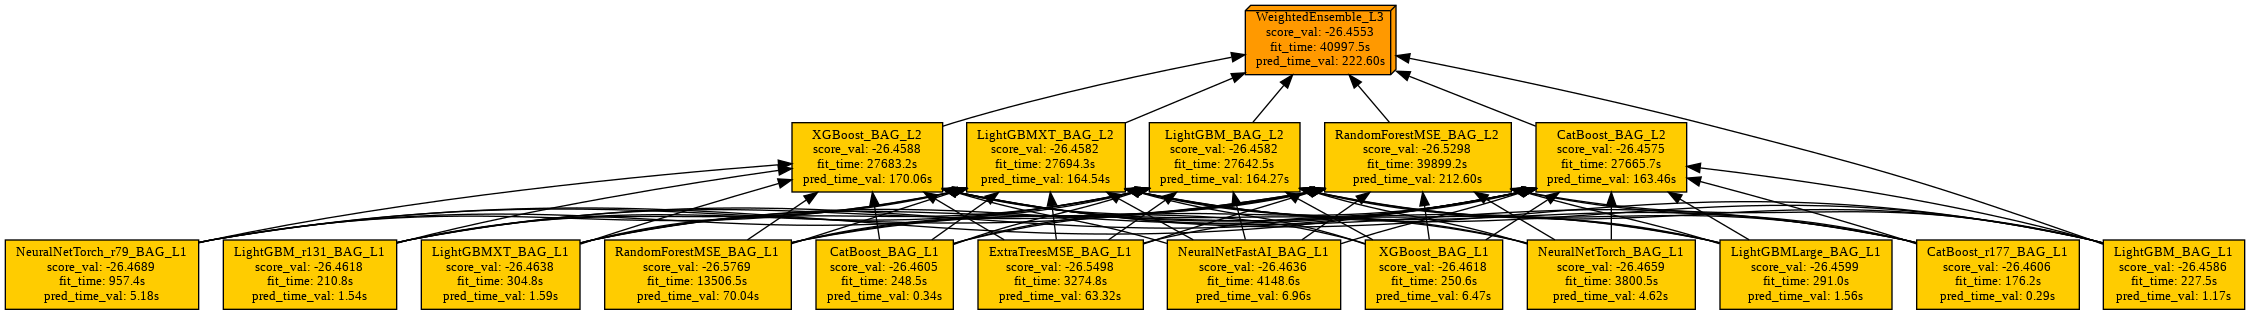

In [20]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_beats_models/ensemble_model.png'))

In [21]:
# !zip -r /kaggle/working/AG_beats_models /kaggle/working/AG_beats_models.zip
!zip -r AG_beats_predictions{NAME_EXT}.zip /kaggle/working/AG_beats_predictions{NAME_EXT}

  adding: kaggle/working/AG_beats_predictions_FE136_CPU/ (stored 0%)
  adding: kaggle/working/AG_beats_predictions_FE136_CPU/oof_ag_FE136_CPU.parquet (deflated 11%)
  adding: kaggle/working/AG_beats_predictions_FE136_CPU/pred_ag_FE136_CPU.parquet (deflated 13%)


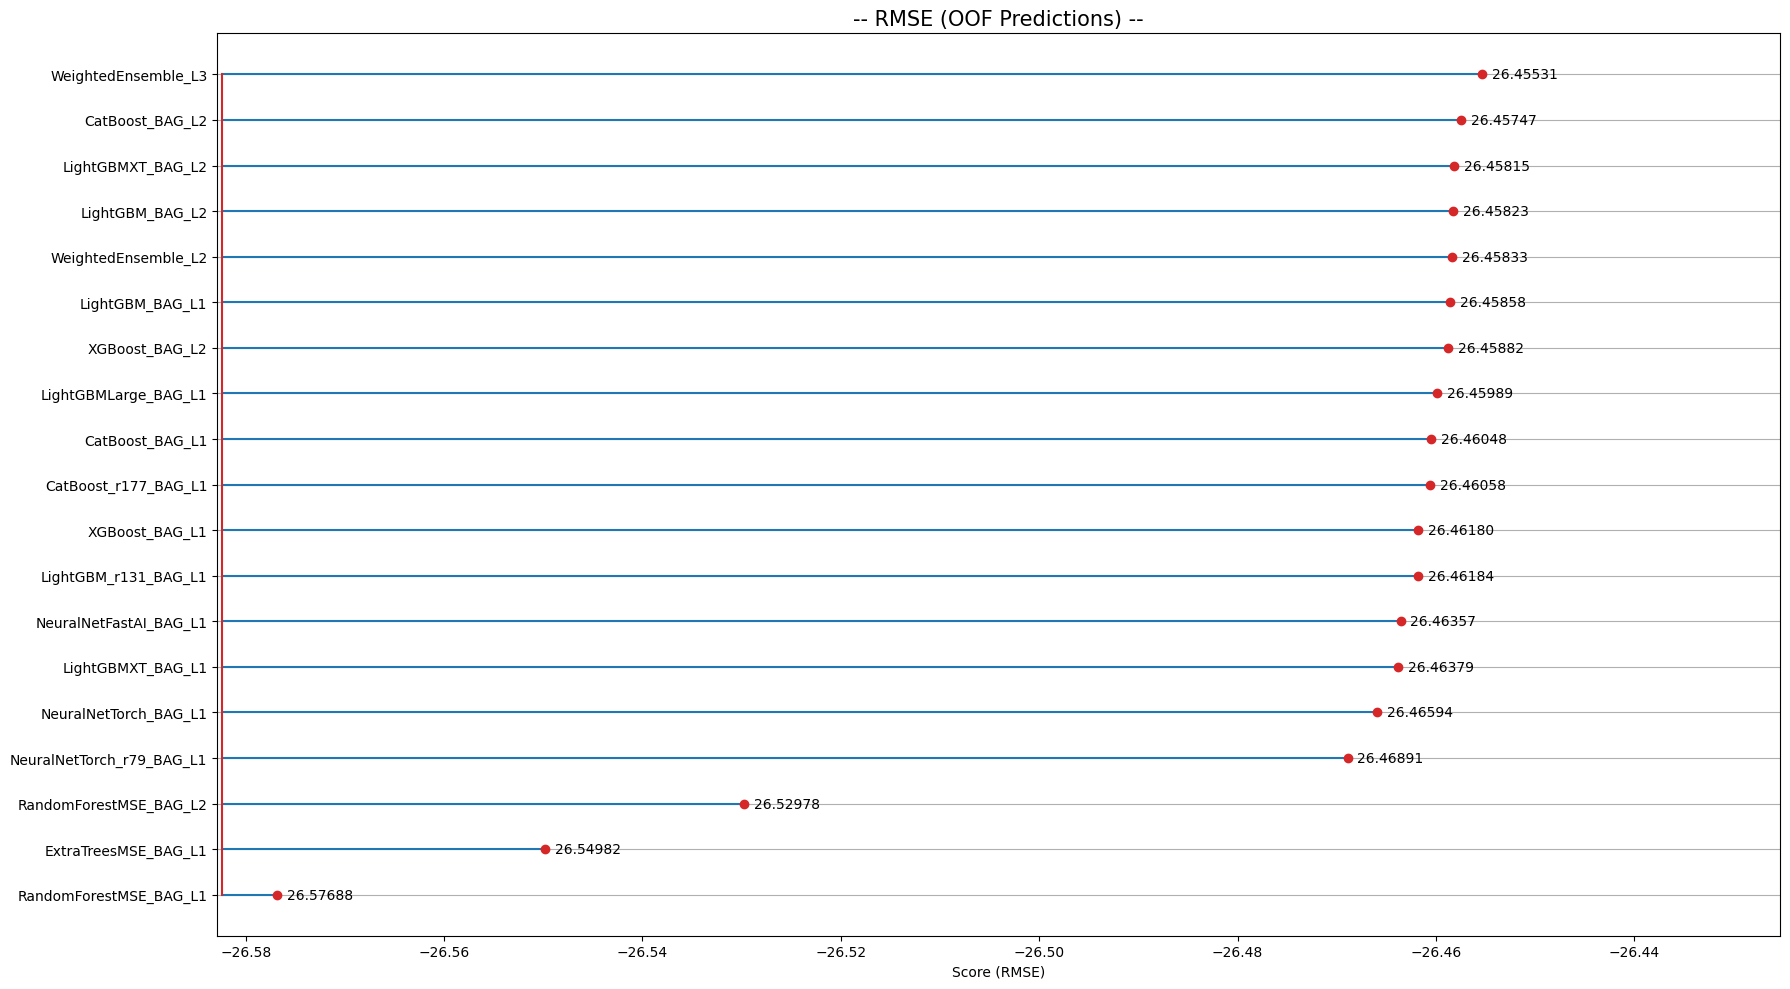

In [22]:
## -- EXTRACT MODEL AND SCORES --
result_dict = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 10))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.03)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE (OOF Predictions) --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [23]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_beats_models
!rm -r /kaggle/working/AG_beats_predictions{NAME_EXT}

In [24]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

